### Import the required packages

In [1]:
import requests
import os
import sys
from time import sleep
import json
import urllib2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wand.image import Image as WImage
from py2cytoscape import cyrest
%matplotlib inline

### Define required functions

### Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the STRING app, if you haven't already: http://apps.cytoscape.org/apps/stringapp
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

In [3]:
cytoscape=cyrest.cyclient()
cytoscape.version()

cytoscapeVersion 3.6.0
apiVersion v1


cleanse the palette before importing new networks and styles

In [4]:
cytoscape.vizmap.apply(styles="default")

################################################
# Step 1: Getting Disease Networks
################################################

Use Cytoscape to query the STRING database for networks of genes associated with breast cancer and ovarian cancer.

**If the STRING app is not installed, no error is reported, but your network  will be empty**

### Query STRING database by disease to generate networks

#### Breast cancer

In [5]:
from py2cytoscape.cyrest.base import api

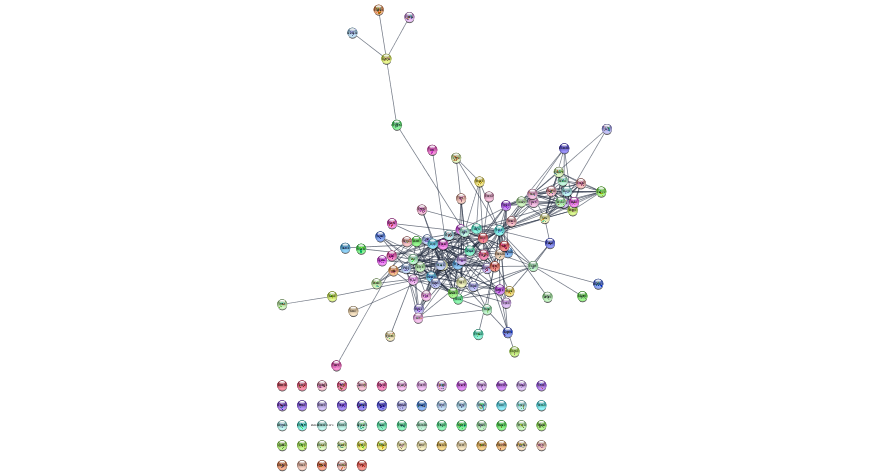

In [6]:
api(namespace="string",command="disease query",PARAMS={"disease":"breast cancer","cutoff":"0.9",
                                                       "species":"Homo sapiens","limit":"150"})
cytoscape.result()

Here we are using Cytoscape's command line syntax, converting it to a CyREST url, and then making a PUT request. 

#### Ovarian cancer

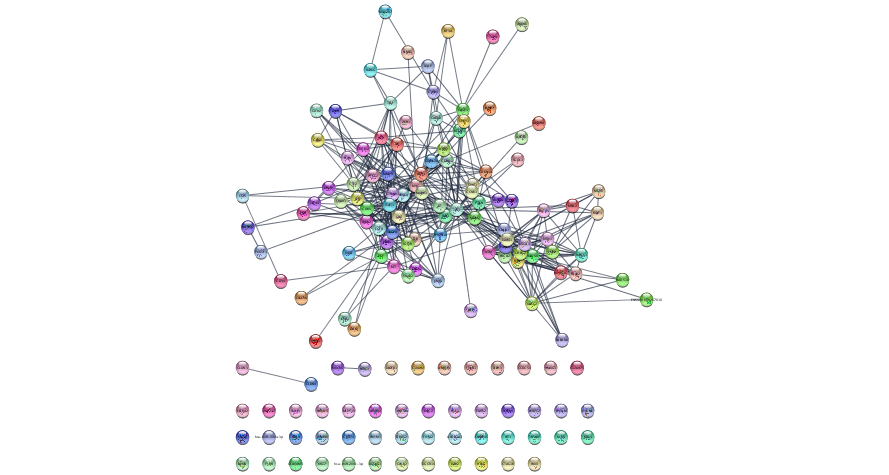

In [7]:
api(namespace="string",command="disease query",PARAMS={"disease":"ovarian cancer","cutoff":"0.9",
                                                       "species":"Homo sapiens","limit":"150"})
cytoscape.result()

################################################
# Step 2: Interacting with Cytoscape 
################################################

Now that we've got a couple networks into Cytoscape, let's see what we can go with them from R...

### Get list of networks 

In [8]:
cytoscape.network.list()

[19809, 18727]

### Layout network

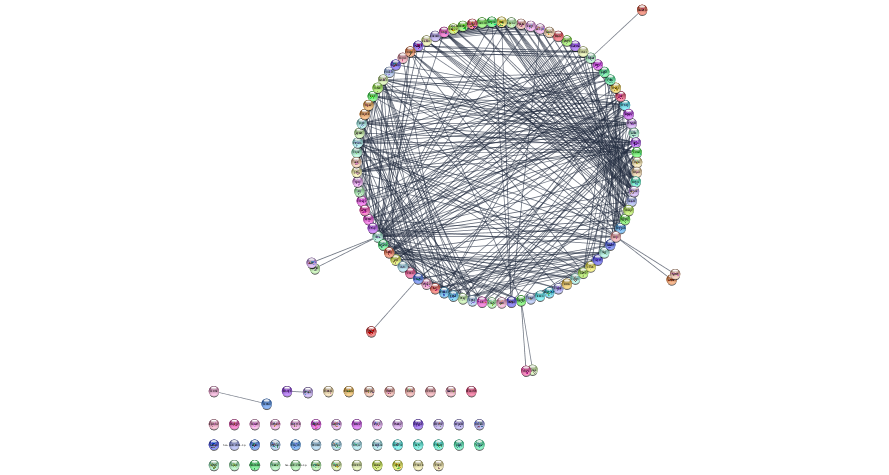

In [9]:
cytoscape.layout.circular()
cytoscape.result()

#### List of layout algorithms available

In [10]:
print cytoscape.commands.namespace("layout")

Available commands for 'layout':
  apply preferred
  attribute-circle
  attributes-layout
  circular
  copycat
  cose
  degree-circle
  force-directed
  force-directed-cl
  fruchterman-rheingold
  genemania-force-directed
  get preferred
  grid
  hierarchical
  isom
  kamada-kawai
  set preferred
  stacked-node-layout



#### Layout with parameters!

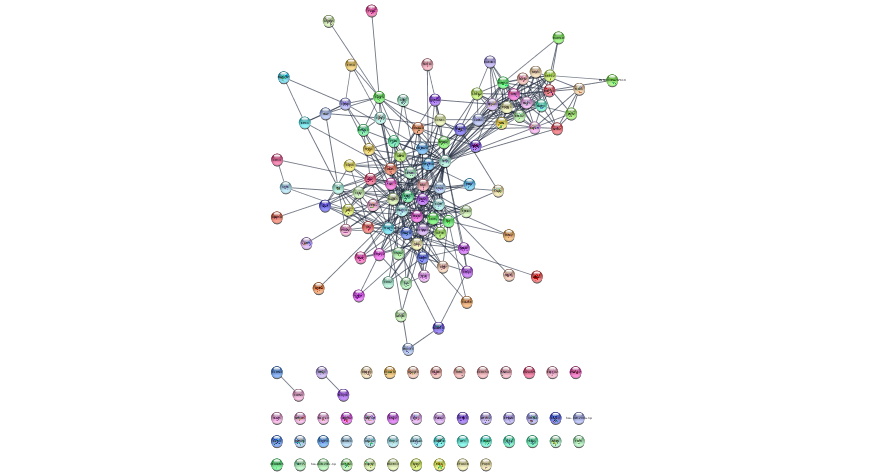

In [11]:
cytoscape.layout.force_directed(defaultSpringCoefficient=".000004", defaultSpringLength="5")
cytoscape.result()

In [12]:
print cytoscape.commands.command("layout","force-directed")

Available arguments for 'layout force-directed':
  defaultEdgeWeight
  defaultNodeMass
  defaultSpringCoefficient
  defaultSpringLength
  EdgeAttribute
  isDeterministic
  maxWeightCutoff
  minWeightCutoff
  network
  NodeAttribute
  nodeList
  numIterations
  singlePartition
  Type



These *command* calls will allow you to interrogate the layouts and parameters available in your active Cytoscape session. This includes any layouts added by apps you've installed!

### Get table data from network
Now, let's look at the tablular data associated with our STRING networks...

In [13]:
cytoscape.node.list_attributes()

[u'SUID',
 u'shared name',
 u'name',
 u'selected',
 u'canonical name',
 u'display name',
 u'full name',
 u'database identifier',
 u'description',
 u'@id',
 u'namespace',
 u'node type',
 u'query term',
 u'sequence',
 u'species',
 u'STRING style',
 u'enhancedLabel Passthrough',
 u'canonical',
 u'compartment chloroplast',
 u'compartment cytoskeleton',
 u'compartment cytosol',
 u'compartment endoplasmic reticulum',
 u'compartment endosome',
 u'compartment extracellular',
 u'compartment golgi apparatus',
 u'compartment lysosome',
 u'compartment mitochondrion',
 u'compartment nucleus',
 u'compartment peroxisome',
 u'compartment plasma membrane',
 u'compartment vacuole',
 u'image',
 u'target development level',
 u'target family',
 u'tissue adrenal gland',
 u'tissue blood',
 u'tissue bone',
 u'tissue bone marrow',
 u'tissue eye',
 u'tissue gall bladder',
 u'tissue heart',
 u'tissue intestine',
 u'tissue kidney',
 u'tissue liver',
 u'tissue lung',
 u'tissue lymph node',
 u'tissue muscle',
 u'ti

One of the great things about the STRING database is all the node and edge attriubtes they provide. Let's pull some of it into R to play with...

#### Retrieve disease scores 
We can retrieve any set of columns from Cytoscape and store them as an R data frame.

In [14]:
disease_score_table=cytoscape.table.getTable(columns=['disease score'],table='node')
disease_score_table.head()

,disease score
9606.ENSP00000322421,1.657067
9606.ENSP00000367207,2.085723
9606.ENSP00000233146,5.000000
9606.ENSP00000261058,1.836101
9606.ENSP00000336701,5.000000


#### Plot distribution and pick threshold
Now you can use python like you normally would explore the data.

Text(0,0.5,u'frequency')

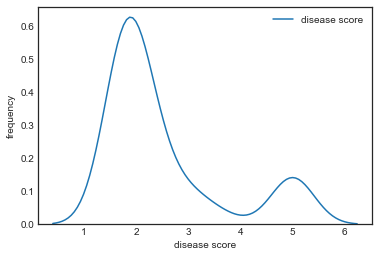

In [15]:
sns.set_style("white")
sns.kdeplot( disease_score_table["disease score"] )
plt.xlabel("disease score")
plt.ylabel("frequency")

### Generate subnetworks
In order to reflect your exploration back onto the network, let's generate subnetworks...

...from top quartile of 'disease score'

In [16]:
top_quart=disease_score_table[["disease score"]].quantile(0.75)[0]
top_nodes=disease_score_table[disease_score_table["disease score"]>top_quart].index.tolist()

In [17]:
values="name:"+",".join(top_nodes)
cytoscape.network.create(source="current",excludeEdges="false",nodeList=values)
cytoscape.network.rename(name="top disease quartile",sourceNetwork="current")

21055

...of connected nodes only

In [18]:
cytoscape.network.create(edgeList='all',nodeList='selected')

{u'network': 21185, u'view': 21195}

...from first neighbors of top 3 genes, using the network connectivity together with the data to direct discovery.

In [19]:
cytoscape.network.set_current(network="String Network - ovarian cancer")

In [20]:
top_nodes=disease_score_table.sort_values(by=["disease score"],\
                                         ascending=False)
top_nodes=top_nodes.index.tolist()[:3]
print top_nodes

[u'9606.ENSP00000263967', u'9606.ENSP00000344456', u'9606.ENSP00000265433']


In [21]:
cytoscape.network.select(nodeList="name:"+",".join(top_nodes))

[19855, 19893, 19946]

In [22]:
cytoscape.network.select(firstNeighbors="")

[19855, 19893, 19946]

In [23]:
cytoscape.network.create(nodeList='selected')

{u'network': 21302, u'view': 21312}

In [24]:
cytoscape.network.rename(name="top disease neighbors")

21302

...from diffusion algorithm starting with top 3 genes, using the network connectivity in a more subtle way than just first-degree neighbors.

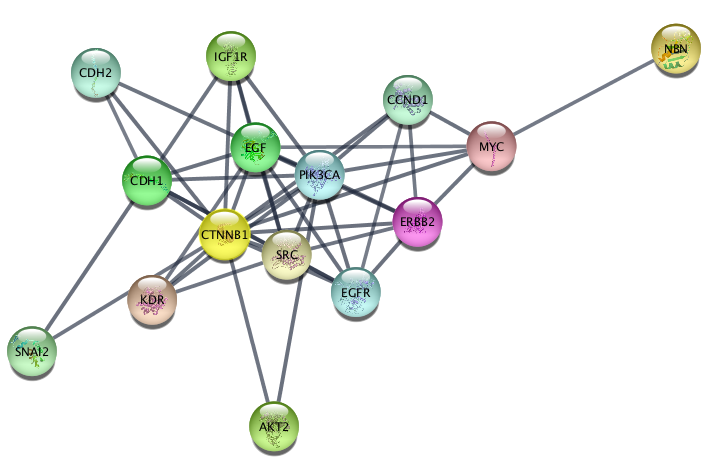

In [25]:
cytoscape.network.set_current(network="String Network - ovarian cancer")
sleep(2)
cytoscape.network.select( nodeList="name:"+",".join(top_nodes) )
sleep(2)
cytoscape.diffusion.diffuse()
sleep(2)
cytoscape.network.create(nodeList="selected")
sleep(2)
cytoscape.layout.force_directed()
sleep(2)
cytoscape.network.rename(name="top disease diffusion")
sleep(2)
cytoscape.result()

################################################
# Step 3: Visualizing data on networks
################################################

### Load datasets
Downloaded TCGA data from https://portal.gdc.cancer.gov/ and preprocessed as R objects. Also available via each TCGA publication, e.g.:
 
* Breast: https://tcga-data.nci.nih.gov/docs/publications/brca_2012/
* Ovarian: https://tcga-data.nci.nih.gov/docs/publications/ov_2011/

In [26]:
brc_expr=pd.read_table("data/brc.exp.tsv")
brc_mut=pd.read_table("data/brc.mut.tsv")

### Breast Cancer Datset
These datasets are similar to the data frames you normarlly encounter in R. For diversity, one using row.names to store corresponding gene names and the other uses the first column. Both are easy to import into Cytoscape.

In [27]:
brc_expr.head()

,expr.mean
ELMO2,-0.000167
CREB3L1,-0.005408
RPS11,0.018381
PNMA1,-0.065037
MMP2,-0.074444


In [28]:
brc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
13,A1CF,2,2
14,A2BP1,3,3
15,A2M,3,2
16,A2ML1,4,4
17,A4GALT,1,0


Let's return to the Breast Cancer network...

In [29]:
cytoscape.network.set_current(network="String Network - breast cancer")
cytoscape.layout.force_directed(defaultSpringCoefficient=".000004",defaultSpringLength="5")

...and use the helper function from r2cytoscape called *loadTableData*


In [30]:
cytoscape.table.loadTableData(brc_expr,table_key_column="display name")
cytoscape.table.loadTableData(brc_mut,df_key='Hugo_Symbol',table_key_column="display name")

''

#### Visual styles
Let's create a new style to visualize our imported data
...starting with the basics, we will specify a few defaults and obvious mappings in a custom style all our own.

In [31]:
defaults_dic={"NODE_SHAPE":"ellipse",\
               "NODE_SIZE":"60",\
               "NODE_FILL_COLOR":"#AAAAAA",\
               "EDGE_TRANSPARENCY":"120"}
defaults_list=cytoscape.vizmap.simple_defaults(defaults_dic)

NODE_LABEL=cytoscape.vizmap.mapVisualProperty(visualProperty="NODE_LABEL",mappingType="passthrough",mappingColumn="display name")

cytoscape.vizmap.create_style(title="dataStyle",defaults=defaults_list,mappings=[NODE_LABEL])
sleep(2)
cytoscape.vizmap.apply(styles="dataStyle")

Creating new style.
response status 201


[19264]

Now let's update the style with a mapping for mean expression. The first step is to grab the column data from Cytoscape and pull out the min and max to define our data mapping range of values.

In [32]:
brc_expr_network = cytoscape.table.getTable(columns=['expr.mean'],table='node')

In [33]:
min_brc_expr = min(brc_expr_network.dropna()['expr.mean'].tolist())
max_brc_expr = max(brc_expr_network.dropna()['expr.mean'].tolist())

min_brc_expr=abs(min_brc_expr)
max_brc_expr=abs(max_brc_expr)

max_brc_expr=max([min_brc_expr,max_brc_expr])
min_brc_expr=max_brc_expr*-1.0

In python we check matplotlib's color maps to help us pick good colors to pair with our data values: https://matplotlib.org/examples/color/colormaps_reference.html

In [34]:
cmap = matplotlib.cm.get_cmap("bwr")
norm = matplotlib.colors.Normalize(vmin=min_brc_expr, vmax=max_brc_expr)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_expr)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(0)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_expr)))  

print min_color, center_color, max_color

#0000ff #fffefe #ff0000


Finally, we use the handy *mapVisualProperty* function to construct the data object that CyREST needs to specify style mappings and then we'll send them off to Cytoscape with *updateStyleMappings*.

response status 201


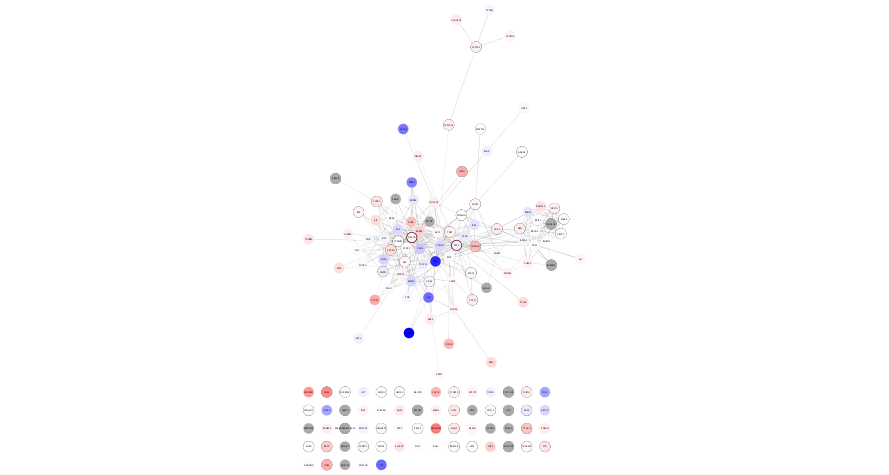

In [35]:
NODE_FILL_COLOR=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_FILL_COLOR',mappingType="continuous",\
                                                   mappingColumn='expr.mean',lower=[min_brc_expr,min_color],\
                                                   center=[0.0,center_color],upper=[max_brc_expr,max_color])
cytoscape.vizmap.update_style(title="dataStyle",mappings=[NODE_FILL_COLOR])
cytoscape.vizmap.apply(styles="dataStyle")
cytoscape.result()

**Pro-tip: depending on your data, it may be better to balance your color range over negative and positive values bounded by the largest min or max data value, so that color intensity scales similarly in both directions.**

#### Visualize mutation data
OK, now let's update with a mapping for mutation. Here are all the same steps, but this time mapping mutation counts to *both* node border width and color. 

response status 201
response status 201


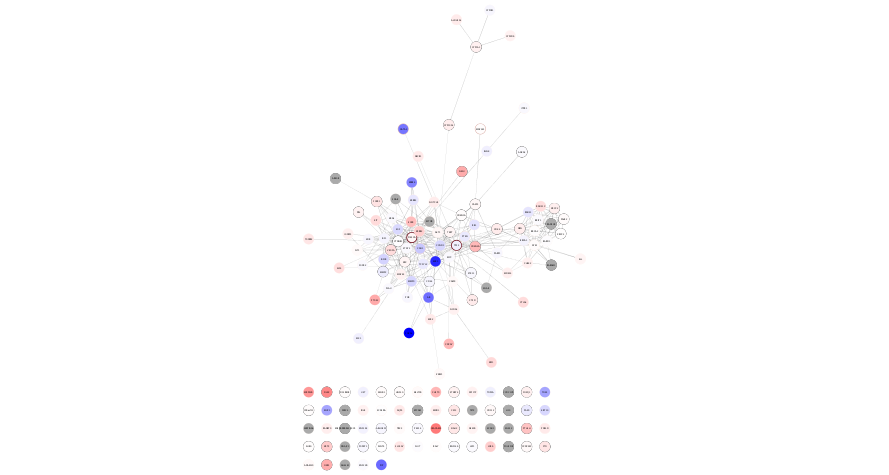

In [36]:
brc_mut_network = cytoscape.table.getTable(columns=['mut_count'],table='node') 
min_brc_mut = min(brc_mut_network.dropna()['mut_count'].tolist())
max_brc_mut = max(brc_mut_network.dropna()['mut_count'].tolist())

cent_brc_mut=20.0

cmap = matplotlib.cm.get_cmap("Reds")
norm = matplotlib.colors.Normalize(vmin=min_brc_mut, vmax=max_brc_mut)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_mut)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(cent_brc_mut)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_mut)))  

NODE_BORDER_PAINT=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_BORDER_PAINT',mappingType="continuous",\
                                                   mappingColumn='mut_count',lower=[min_brc_mut,min_color],\
                                                   center=[20,center_color],upper=[max_brc_mut,max_color])
cytoscape.vizmap.update_style(title="dataStyle",mappings=[NODE_BORDER_PAINT])
cytoscape.vizmap.apply(styles="dataStyle")

NODE_BORDER_WIDTH=cytoscape.vizmap.mapVisualProperty(visualProperty="NODE_BORDER_WIDTH", mappingType="continuous",\
                                    mappingColumn='mut_count',lower=[min_brc_mut,2],center=[20,4],\
                                    upper=[max_brc_mut,8])
cytoscape.vizmap.update_style(title="dataStyle",mappings=[NODE_BORDER_WIDTH])
cytoscape.vizmap.apply(styles="dataStyle")
cytoscape.result()

#### Subnetwork based on diffusion from heavily mutated nodes
Now, let's pull in what we learned about subnetwork selection and apply it here...

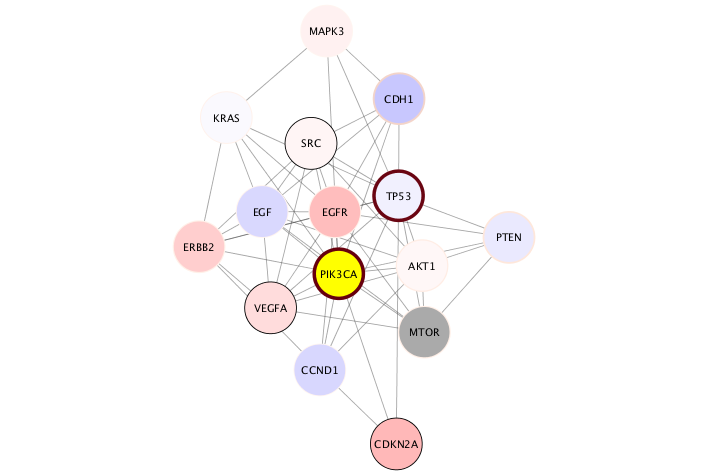

In [37]:
top_mut=brc_mut_network.dropna().sort_values(by=["mut_count"],ascending=False)
top_mut=top_mut.index.tolist()[:2]

cytoscape.network.select(nodeList="name:"+",".join(top_mut))
sleep(2)
cytoscape.diffusion.diffuse()
sleep(2)
cytoscape.network.create(nodeList='selected')
cytoscape.layout.force_directed()
cytoscape.network.rename(name="top mutated diffusion")
cytoscape.result()

The top mutated genes are based on TCGA data and the diffusion algorithm is operating based on the network connectivity from STRING data, leading to a focused subnetwork view of critical Breast Cancer genes with mean patient expression data mapped to fill color. Now *that's* data integration!

**Pro-tip: You can generate a legend for this in Cytoscape Style tab > Options > Create style...  This is no yet available as a command. Coming soon!**


### Ovarian Cancer Datset
But what about the other network and datasets? Do we have to repeat *all* of those steps again?  Actually, no!

First, let's switch back over to the Ovarian Cancer network and load our data.

In [38]:
ovc_expr=pd.read_table("data/ovc.expr.tsv")
ovc_mut=pd.read_table("data/ovc.mut.tsv")

In [39]:
cytoscape.network.set_current(network="String Network - ovarian cancer")
cytoscape.table.loadTableData(df=ovc_expr, table_key_column="display name")
cytoscape.table.loadTableData(df=ovc_mut,df_key='Hugo_Symbol',table_key_column="display name")

''

**Because we used the same column names in our original data frames, now we can simply apply the *same* visual style created above!**

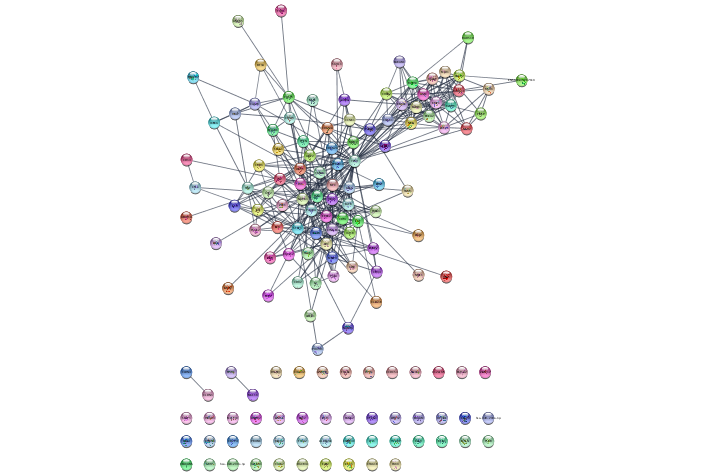

In [40]:
cytoscape.vizmap.apply(styles="dataStyle")
cytoscape.network.deselect(nodeList='all', edgeList='all')
cytoscape.result()

Reusing the same style for both breast and ovarian cancers, we can compare the relative expression and mutation counts across the two datasets. 
For example, notice in the case of ovarian cancer: **decreased** range of mean expression and **fewer** mega-mutated genes.

##########################################
# Step 4: Saving, sharing and publishing
##########################################

### Saving a Cytoscape session file
Session files save *everything*. As with most project software, we recommend saving often!

In [41]:
cytoscape.session.save_as(session_file="cytoscape")

**Note: If you don't specify a complete path, the files will be save relative to your Cytoscape installation directory, e.g., /Applications/Cytoscape_v3.6.0/... or somewhere you don't have write permissions. So, it's probably better to specify one...**

### Exporting high resolution image files
You can export extremely high resolution images, including vector graphic formats.

In [42]:
cytoscape.network.deselect(nodeList='all', edgeList='all')
cytoscape.view.fit_content()
cytoscape.view.export(options="PDF",OutputFile="cytoscape_image")

{u'file': u'/Applications/Cytoscape_v3.6.0/cytoscape_image.pdf'}

### Exporting interactive web pages via cytoscape.js
You can export the network model in multiple standard formats. And if you want to get really fancy, you can export the model and style in cytoscape.js formats and host interactive views of your network analysis and visualization results online!

In [43]:
cytoscape.network.export(options="CYJS",OutputFile="cytoscape_network")
cytoscape.vizmap.export(options="json",OutputFile="cytoscape_style")

{u'file': u'/Applications/Cytoscape_v3.6.0/cytoscape_style.json'}

More details in Cytoscape manual chapter on [Interactive Web Applications](http://manual.cytoscape.org/en/stable/Export_Your_Data.html#as-an-interactive-web-application-new-in-3-2-0)


And in Cytoscape, you can File>Export as Web Page... to produce a folder of cytoscape.js files and html.


### Additional network analysis and visualization options
* Mapping edge attributes to edge thickness, color and/or transparency (e.g., score or experiments) 
    * EDGE_WIDTH, EDGE_COLOR, EDGE TRANSPARENCY
* Edge bundling
    * bundleEdges()
* Directional edge animation
    * applyStyle('Marquee')
    * updateStyleDefaults(style.name,list('Edge Line Type'='Marquee_Dash'))
* Visualize two or more datasets as split-fill or pie chart, or patient-specific data as radial Circos plot
    * pending support for charts...
* Merge two (or more) networks
    * copyCytoscapeNetwork() or 'network clone'; then addGraphToGraph() (Union only)
    * using igraph: intersection(g1,g2), union(), difference(); followed by toCytoscape() and send2cy()

## swagger
http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json#/

##########################################
# Step 5: Wrapping up
##########################################

You should now know how to...

* Connect to Cytoscape from Python
* Retrieve disease networks from STRING
* Interact with Cytoscape via commands, CyREST, and py2cytoscape
* Load various data types onto networks
* Set visual style defaults and mappings
* Perform selection and create subnetworks
* Save, share and publish your networks
* Find more information on Cytoscape automation

#### Resources
* Growing collection of [cytoscape automation resources](https://github.com/cytoscape/cytoscape-automation/), including **this** tutorial
* Growing collection of [cytoscape tutorial materials](https://github.com/cytoscape/cytoscape-tutorials)
* Active community on [cytoscape-helpdesk](https://groups.google.com/forum/#!forum/cytoscape-helpdesk) for any Cytoscape related questions and suggestions